In [34]:
import matplotlib.pyplot as plt
import numpy as np
import qutip
from scipy import optimize
from qutip import *

from functionsSqueeze import wQP, wQQ, wQPdot, wQQdot, H, getParams, plotResults

Units: time in $\mu s$ and circular frequency in MHz<br/>
    $\hbar$ is set to 1 => the hamiltonian has unit MHz

In [51]:
n = 30 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

timesQQ = np.linspace(-0.8, 2.5, 500)
argsQQ = {'n': n,
       'omega': wQQ,
       'omegaDt': wQQdot,
       'omegaArgs': [w0, -0.7*w0, 0.18, -0.7*w0, 0.18, 1.7461],
       'f0': 20/(9*10**-15)}

timesQ = np.linspace(-0.7,0.7, 300)
argsQ = {'n': n,
       'omega': wQP,
       'omegaDt': wQPdot,
       'omegaArgs': [w0, -0.9*w0, 0.18, 0, 0, 0],
       'f0': 10/(9*10**-15)}

timesP = np.linspace(-0.1,0.5, 300)
argsP = {'n': n,
       'omega': wQP,
       'omegaDt': wQPdot,
       'omegaArgs': [w0, 0, 0.18, 0.5*w0, 4*np.pi/(2*w0), 0.],
       'f0': 0.002/(9*10**-15)}

timesQP = np.linspace(-0.8,1, 900)
argsQP = {'n': n,
       'omega': wQP,
       'omegaDt': wQPdot,
       'omegaArgs': [w0, -0.5*w0, 0.18, 0.3*w0, 4*np.pi/(2*w0), 0.3],
       'f0': 0.002/(9*10**-15)}

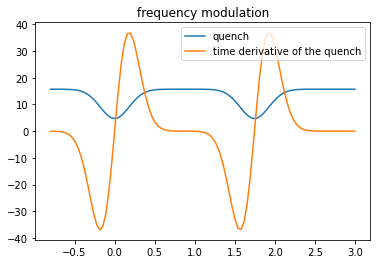

In [52]:
# plot different frequency modulations, to check that they are what I want them to be
tlist = np.linspace(-0.8,3,100)

wDoubleQuench = wQQ(tlist, argsQQ['omegaArgs'])
wDoubleQuenchD = wQQdot(tlist, argsQQ['omegaArgs'])
# wParam = wQP(tlist, argsP['omegaArgs'])
# wBoth = wQP(tlist, argsQP['omegaArgs'])

plt.plot(tlist, wDoubleQuench, label="quench")
plt.plot(tlist, wDoubleQuenchD, label="time derivative of the quench")
# plt.plot(tlist, wParam, label="parametric")
# plt.plot(tlist, wBoth,":", label="first quench, then parametric")
plt.legend()
plt.title("frequency modulation")
plt.show()

In [53]:
resultQQ = mesolve(H, psi0, timesQQ, args=argsQQ)

In [54]:
# resultQ = mesolve(H, psi0, timesQ, args=argsQ)
# resultP = mesolve(H, psi0, timesP, args=argsP)
# resultQP = mesolve(H, psi0, timesQP, args=argsQP)

<function matplotlib.pyplot.show(*args, **kw)>

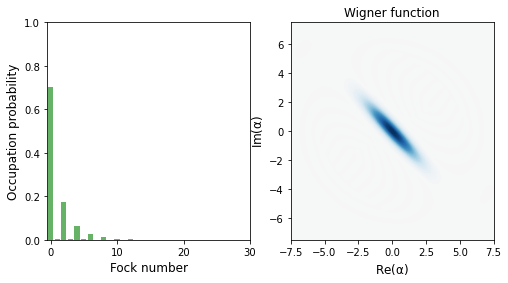

In [55]:
result = resultQQ
psi = result.states[-1]

plot_wigner_fock_distribution(psi)
plt.show

|alpha|= 0.01729381377905263 , xi = (0.005880143748626618+0.8844957528354569j) , nBar = 1.0092153297866862 , nT = 0.010955675896032996


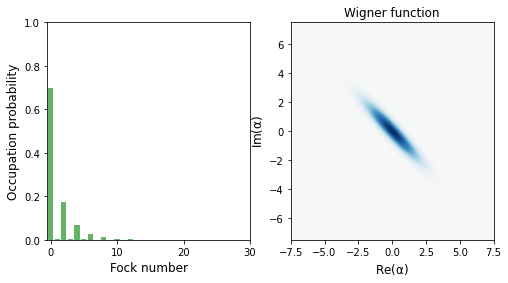

In [56]:
alpha, xi, nBar, nT = getParams(psi)
print('|alpha|=', np.abs(alpha), ', xi =', xi, ', nBar =', nBar, ', nT =', nT)

psi1 = displace(n, alpha)*squeeze(n, xi)*thermal_dm(n, nT)*squeeze(n, xi).dag()*displace(n, alpha).dag()
plot_wigner_fock_distribution(psi1)
plt.show()

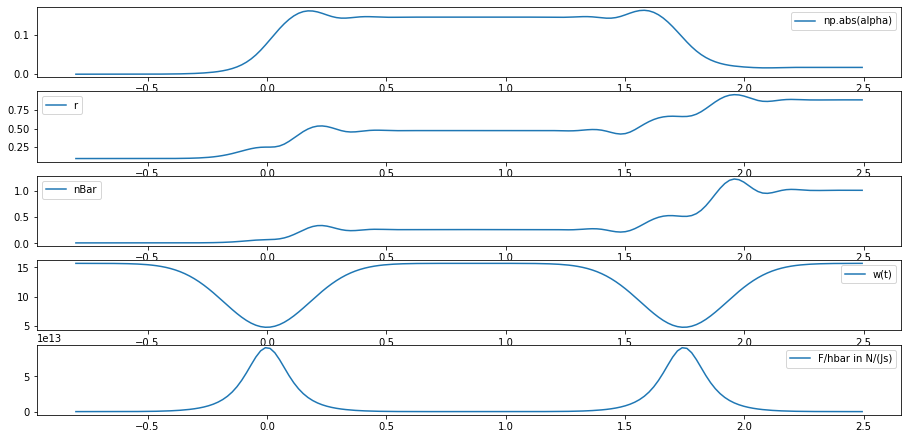

0

In [57]:
plotResults(timesQQ, resultQQ, argsQQ, calculate_nT = False, nSkipp = 3, showProgress = False)

In [25]:
# checking how |alpha| behaves when the delay is changed through 1 period T 

n = 30 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

delays = np.linspace(4*T, 5*T, 37) # at least 4T

alphaF = []

# speeding up things: only calculate the first quench once

times1 = np.linspace(-1, 2*T, 200)
argsQQ = {'n': n,
   'omega': wQQ,
   'omegaDt': wQQdot,
   'omegaArgs': [w0, -0.7*w0, 0.18, -0.7*w0, 0.18, 4*T],
   'f0': 2/(9*10**-15)}

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha1,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
for dt in delays:
    times2 = np.linspace(2*T, 3, 200)
    argsQQ = {'n': n,
       'omega': wQQ,
       'omegaDt': wQQdot,
       'omegaArgs': [w0, -0.7*w0, 0.18, -0.65*w0, 0.18, dt],
       'f0': 2/(9*10**-15)}
    
    resultQQ = mesolve(H, psi1, times2, args=argsQQ)
    

    psi2 = resultQQ.states[-1]
    alpha2,_,_,_ = getParams(psi2, False)
    alphaF.append(np.abs(alpha2))
    print('\r', "Progress: ", round(100*(dt-delays[0])/(delays[-1]-delays[0])), " %", end = '')

 Progress:  100.0  %

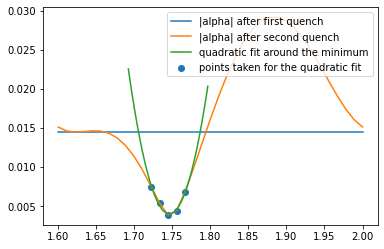

1.7461035265984148


In [48]:
def fitFkt(x, a, b, c):
    return(a*x**2 + b*x + c)

# take two points left and right of the minimum for a quadratic fit
idx = alphaF.index(min(alphaF))
xFit = delays[idx-2:idx+3]
yFit = alphaF[idx-2:idx+3]

params,_ = optimize.curve_fit(fitFkt, xFit, yFit, p0 = [0, 0, 0]) # fit
xlist = np.linspace(xFit[0]-0.03, xFit[-1]+0.03, 1000)

plt.plot([delays[0], delays[-1]], [np.abs(alpha1), np.abs(alpha1)], label = "|alpha| after first quench")
plt.plot(delays, alphaF, label = "|alpha| after second quench")
plt.plot(xlist, fitFkt(xlist, params[0], params[1], params[2]), label = "quadratic fit around the minimum")
plt.scatter(xFit, yFit, label = "points taken for the quadratic fit")
plt.legend()
plt.show()

delayOpt = -params[1]/(2*params[0])
print(delayOpt)

In [12]:
# check if the number off full periods T between the two quenches plays a role (result: No)

n = 30 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

delays = np.linspace(delayOpt, delayOpt + 12*T, 13) # at least 4T

alphaF = []

# speeding up things: only calculate the first quench once

times1 = np.linspace(-1, 2*T, 200)
argsQQ = {'n': n,
   'omega': wQQ,
   'omegaDt': wQQdot,
   'omegaArgs': [w0, -0.7*w0, 0.18, -0.65*w0, 0.18, dt],
   'f0': 2/(9*10**-15)}

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha1,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
i = 0
for dt in delays:
    times2 = np.linspace(2*T, dt + 2*T, 200+50*i) # keep spacing the same
    argsQQ = {'n': n,
       'omega': wQQ,
       'omegaDt': wQQdot,
       'omegaArgs': [w0, -0.7*w0, 0.18, -0.65*w0, 0.18, dt],
       'f0': 2/(9*10**-15)}
    
    resultQQ = mesolve(H, psi1, times2, args=argsQQ)
    
    psi2 = resultQQ.states[-1]
    alpha2,_,_,_ = getParams(psi2, False)
    alphaF.append(np.abs(alpha2))
    i += 1
    print('\r', "Progress: ", round(100*(dt-delays[0])/(delays[-1]-delays[0])), " %", end = '')

 Progress:  100.0  %

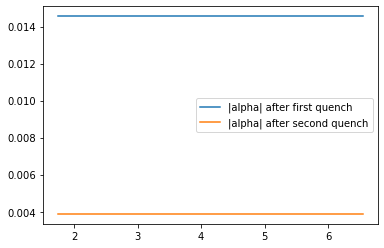

In [13]:
plt.plot([delays[0], delays[-1]], [np.abs(alpha1), np.abs(alpha1)], label = "|alpha| after first quench")
plt.plot(delays, alphaF, label = "|alpha| after second quench")
plt.legend()
plt.show()

In [49]:
# check the influence of the second quenches strength (=> should be the same as the first one)

n = 30 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

dw2s = np.linspace(-0.8, -0.3, 37)

alphaF = []

times1 = np.linspace(-1, 2*T, 200)
argsQQ = {'n': n,
   'omega': wQQ,
   'omegaDt': wQQdot,
   'omegaArgs': [w0, -0.7*w0, 0.18, -0.7*w0, 0.18, delayOpt],
   'f0': 2/(9*10**-15)}

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha1,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several dw2s and get final alphas (= alpha2)
times2 = np.linspace(2*T, 3, 200)
for dw2 in dw2s:
    argsQQ = {'n': n,
       'omega': wQQ,
       'omegaDt': wQQdot,
       'omegaArgs': [w0, -0.7*w0, 0.18, dw2*w0, 0.18, delayOpt],
       'f0': 2/(9*10**-15)}
    
    resultQQ = mesolve(H, psi1, times2, args=argsQQ)

    psi2 = resultQQ.states[-1]
    alpha2,_,_,_ = getParams(psi2, False)
    alphaF.append(np.abs(alpha2))
    print('\r', "Progress: ", round(100*(dw2-dw2s[0])/(dw2s[-1]-dw2s[0])), " %", end = '')

 Progress:  100.0  %

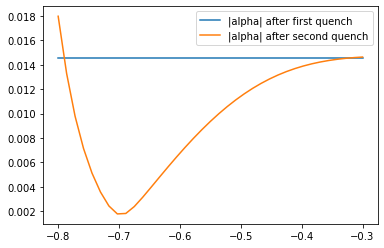

-0.7027777777777778


In [50]:
plt.plot([dw2s[0], dw2s[-1]], [np.abs(alpha1), np.abs(alpha1)], label = "|alpha| after first quench")
plt.plot(dw2s, alphaF, label = "|alpha| after second quench")
plt.legend()
plt.show()

dw2Opt = dw2s[alphaF.index(min(alphaF))]
print(dw2Opt)